# 載入所需套件

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from scipy import poly1d
from pykalman import KalmanFilter
from datetime import datetime

%matplotlib inline

register_matplotlib_converters()

# Kalman Filters

# 移動平均

In [2]:
start=datetime(2017,1,1)
end=datetime.now().date()

adj_close=pdr.DataReader('LMT','yahoo',start,end)['Adj Close']

kf=KalmanFilter(transition_matrices=[1],observation_matrices=[1],initial_state_mean=0,
                initial_state_covariance=1,observation_covariance=1,transition_covariance=0.01)

state_mean,_=kf.filter(adj_close.values)
state_mean=pd.Series(state_mean.flatten(),index=adj_close.index)

mean_30=adj_close.rolling(window=30).mean()
mean_60=adj_close.rolling(window=60).mean()
mean_90=adj_close.rolling(window=90).mean()

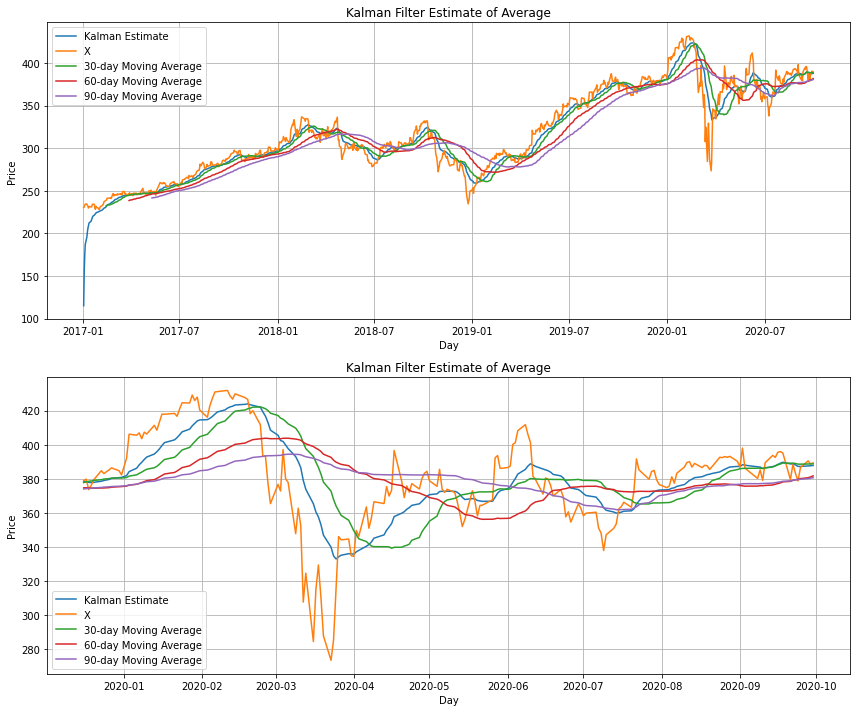

In [3]:
fig,axes=plt.subplots(2,figsize=(12,10))
axes[0].plot(state_mean,label='Kalman Estimate')
axes[0].plot(adj_close,label='X')
axes[0].plot(mean_30,label='30-day Moving Average')
axes[0].plot(mean_60,label='60-day Moving Average')
axes[0].plot(mean_90,label='90-day Moving Average')
axes[0].set_title('Kalman Filter Estimate of Average',fontsize=12)
axes[0].set_xlabel('Day',fontsize=10)
axes[0].set_ylabel('Price',fontsize=10)
axes[0].legend()
axes[0].grid()

axes[1].plot(state_mean[-200:],label='Kalman Estimate')
axes[1].plot(adj_close[-200:],label='X')
axes[1].plot(mean_30[-200:],label='30-day Moving Average')
axes[1].plot(mean_60[-200:],label='60-day Moving Average')
axes[1].plot(mean_90[-200:],label='90-day Moving Average')
axes[1].set_title('Kalman Filter Estimate of Average',fontsize=12)
axes[1].set_xlabel('Day',fontsize=10)
axes[1].set_ylabel('Price',fontsize=10)
axes[1].legend()
axes[1].grid()
plt.tight_layout()

# 線性迴歸

In [4]:
start=datetime(2017,1,1)
end=datetime.now().date()

x=pdr.DataReader('SPY','yahoo',start,end)['Adj Close']
y=pdr.DataReader('AMZN','yahoo',start,end)['Adj Close']

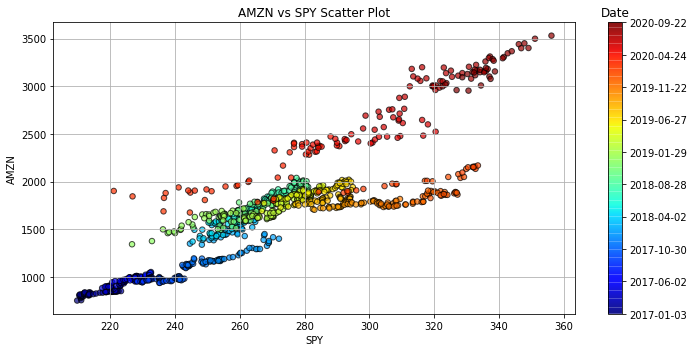

In [5]:
colors=np.linspace(0,1,len(x))

fig,ax=plt.subplots(1,figsize=(10,5))
scatter=ax.scatter(x,y,s=30,c=colors,cmap=plt.cm.jet,edgecolor='k',alpha=0.7)
cbar=plt.colorbar(scatter)
cbar.set_ticks([i/936 for i in range(len(x)) if i%104==0])
cbar.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
cbar.ax.set_title('Date')
ax.set_title('AMZN vs SPY Scatter Plot',fontsize=12)
ax.set_xlabel('SPY',fontsize=10)
ax.set_ylabel('AMZN',fontsize=10)
ax.grid()
plt.tight_layout()

In [6]:
delta=0.001
trans_cov=delta/(1-delta)*np.eye(2)
obs_mat=np.expand_dims(np.vstack([[x],[np.ones(len(x))]]).T,axis=1)

#y is 1-dimensional,(alpha,beta) is 2-dimensional
kf=KalmanFilter(n_dim_obs=1,n_dim_state=2,initial_state_mean=[0,0],initial_state_covariance=np.ones((2,2)),
                transition_matrices=np.eye(2),observation_matrices=obs_mat,observation_covariance=2,transition_covariance=trans_cov)

#Use the observations y to get running estimates and errors for the state parameters
state_means,state_covs=kf.filter(y.values)

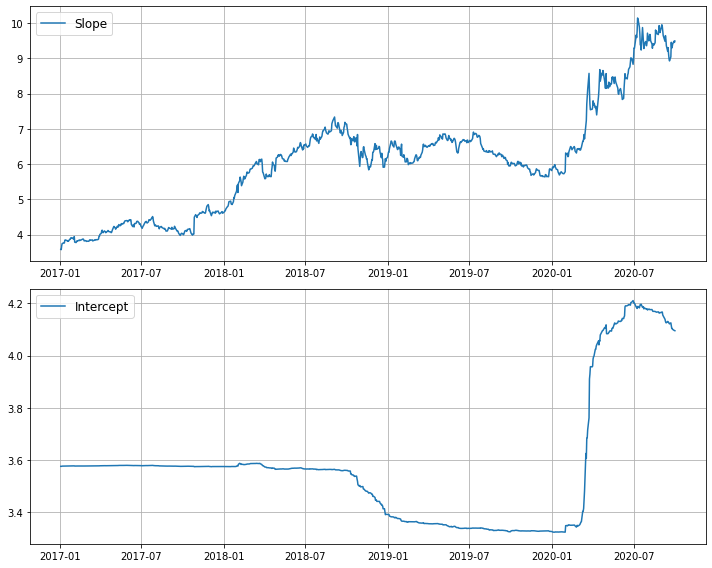

In [7]:
fig,axes=plt.subplots(2,figsize=(10,8),sharex=True)
axes[0].plot(x.index,state_means[:,0],label='Slope')
axes[0].tick_params(axis='x',labelbottom=True)
axes[0].legend(fontsize=12)
axes[0].grid()

axes[1].plot(x.index,state_means[:,1],label='Intercept')
axes[1].tick_params(axis='x',labelbottom=True)
axes[1].legend(fontsize=12)
axes[1].grid()
plt.tight_layout()

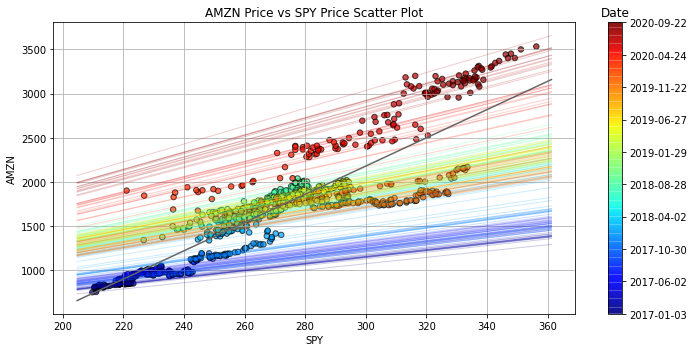

In [8]:
step=5
colors=np.linspace(0,1,len(x))
colors_l=np.linspace(0,1,len(state_means[::step]))
xi=np.linspace(x.min()-5,x.max()+5,2)


fig,ax=plt.subplots(1,figsize=(10,5))
scatter=ax.scatter(x,y,s=30,c=colors,cmap=plt.cm.jet,edgecolor='k',alpha=0.7)
cbar=plt.colorbar(scatter)
cbar.set_ticks([i/936 for i in range(len(x)) if i%104==0])
cbar.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
cbar.ax.set_title('Date')
#Plot every fifth line
for i,beta in enumerate(state_means[::step]):
    ax.plot(xi,beta[0]*xi+beta[1],alpha=0.2,lw=1,c=plt.cm.jet(colors_l[i]))
#Plot the OLS regression line
plt.plot(xi,poly1d(np.polyfit(x,y,1))(xi),'0.4')
ax.set_title('AMZN Price vs SPY Price Scatter Plot',fontsize=12)
ax.set_xlabel('SPY',fontsize=10)
ax.set_ylabel('AMZN',fontsize=10)
ax.grid()
plt.tight_layout()

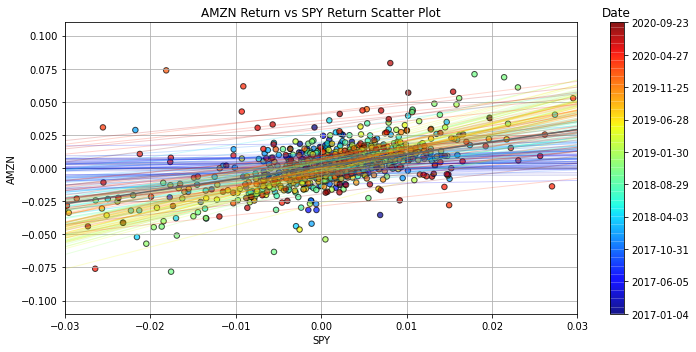

In [9]:
x_r=x.pct_change()[1:]
y_r=y.pct_change()[1:]

delta_r=0.01
trans_cov_r=delta_r/(1-delta_r)*np.eye(2) 
obs_mat_r=np.expand_dims(np.vstack([[x_r],[np.ones(len(x_r))]]).T,axis=1)
#y_r is 1-dimensional,(alpha,beta) is 2-dimensional
kf_r=KalmanFilter(n_dim_obs=1,n_dim_state=2,initial_state_mean=[0,0],initial_state_covariance=np.ones((2,2)),
                  transition_matrices=np.eye(2),observation_matrices=obs_mat_r,observation_covariance=0.01,transition_covariance=trans_cov_r)
state_means_r,_=kf_r.filter(y_r.values)

step=5
xi=np.linspace(x_r.min()-4,x_r.max()+4,2)
colors=np.linspace(0,1,len(x_r))
colors_l = np.linspace(0,1,len(state_means_r[::step]))


fig,ax=plt.subplots(1,figsize=(10,5))
scatter=ax.scatter(x_r,y_r,s=30,c=colors,cmap=plt.cm.jet,edgecolor='k',alpha=0.7)
cbar=plt.colorbar(scatter)
cbar.set_ticks([i/936 for i in range(len(x_r)) if i%104==0])
cbar.ax.set_yticklabels([str(p.date()) for p in x_r[::len(x_r)//9].index])
cbar.ax.set_title('Date')
#Plot every fifth line
for i,beta in enumerate(state_means_r[::step]):
    ax.plot(xi,beta[0]*xi+beta[1],alpha=0.2,lw=1,c=plt.cm.jet(colors_l[i]))
#Plot the OLS regression line
plt.plot(xi,poly1d(np.polyfit(x_r,y_r,1))(xi),'0.4')
ax.set_title('AMZN Return vs SPY Return Scatter Plot',fontsize=12)
ax.set_xlabel('SPY',fontsize=10)
ax.set_ylabel('AMZN',fontsize=10)
ax.axis([-0.03,0.03,-0.11, 0.11])
ax.grid()
plt.tight_layout()